# Using VGG16 Pre-trained on <i>ImageNet</i>

In [7]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16

In [8]:
K.clear_session()

dataset = "../data_set"

### Set up Keras <i>ImageDataGenerator</i>:
<ul>
    <li><b>rotation_range</b> adds a random rotation within the range of +/- the value. </li>
    <li><b>width_shift_range</b> a random horizontal shift of the image within the range of +/- the value.</li>  
    <li><b>height_shift_range</b> a random vertical shift of the image within the range of +/- the value.</li>
    <li><b>shear_range</b> a random stretch of the image at an angle within the range of +/- the value.</li>
    <li><b>horizontal_flip</b> a allows random flips of the image about the horizontal axis</li>
    <li><b>fill_mode</b> some augmentations create empty spaces, fill mode determines how we fill these spaces. "nearest" repeats the pixels and the edge of the space.</li>

</ul>

In [9]:
trdata = ImageDataGenerator(rescale= 1./255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range = 0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

Using the *ImageDataGenerator* to load data from the train, validation and test sets 

In [10]:
traindata = trdata.flow_from_directory(directory=dataset+"/train",
                                       target_size = (224,224), 
                                       color_mode = 'rgb',                                       
                                       class_mode = 'binary', 
                                       batch_size=20,
                                       shuffle=True,
                                       seed=42)

Found 2738 images belonging to 2 classes.


In [11]:
valdata = ImageDataGenerator(rescale= 1./255)
validatedata = valdata.flow_from_directory(directory=dataset+"/validate",
                                      target_size = (224,224),
                                      color_mode = 'rgb',
                                      class_mode = 'binary', 
                                      batch_size=20)

Found 686 images belonging to 2 classes.


In [30]:
tsdata = ImageDataGenerator(rescale= 1./255)
testdata = tsdata.flow_from_directory(directory=dataset+"/test",
                                      target_size = (224,224),
                                      color_mode = 'rgb',
                                      class_mode = 'binary', 
                                      batch_size=20,
                                     shuffle=False)

Found 856 images belonging to 2 classes.


### Loading VGG16 model with weights after being pre-trained on *ImageNet* 

In [13]:
label_map = (traindata.class_indices)
print(label_map)
vggmodel = VGG16(weights="imagenet", include_top='False', input_shape =(224,224,3))

{'not_scorpion': 0, 'scorpion_pepper': 1}


### Creating a new model from VGG16 using the Keras Sequential model API

<ol>
    <li>Create blank model</li>
    <li>Add the all layers from VGG16 except the layers at the top of the network (the classifier)</li>
    <li>Ensure layers are frozen .i.e. not trainable</li>
</ol>

In [14]:
mymodel = Sequential()

for layer in vggmodel.layers[:-4]:
    print(layer.name)
    mymodel.add(layer)
    
del vggmodel

for layer in mymodel.layers:
    print(layer.name, layer.trainable)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


### Adding a classifier to the top of the new model
Adds on 2 fully-connected layers and the final output layer is a single neuron with a sigmoid activation function <br>
This model is going to be used to perform binary classification so a sigmoid is used as the final layer.<br>
The final output is a probability, so a range of 0-1 for the desired class.

In [15]:
new_top = Sequential()
new_top.add(Flatten())
new_top.add(Dense(1024, activation = 'relu'))
new_top.add(Dense(512, activation ='relu'))
new_top.add(Dense(1, activation ='sigmoid'))

In [16]:
for layer in new_top.layers:
    print(layer)

In [17]:
mymodel.add(new_top)
mymodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

### Configure model for training.
<ul>
    <li> <b>optimizer</b> the backpropagation optimization algorithm being used. <b>Adam</b> is typically used with deep neural networks </li>
    <li> <b>loss</b> is the loss function. For a binary classifcation function we use the <b>binary_crossentropy</b> loss function </li>
    <li> <b>metrics</b> the list of metrics to monitor during training </li>
</ul>

In [18]:
mymodel.compile(optimizers.Adam(lr=0.0001), loss='binary_crossentropy',
                        metrics =['accuracy'])

The **fit_generator** provides a way to configure additional training settings.<br>
<ul>
    <li> <b>generator</b> is for the training data generator </li>
    <li> <b>steps_per_epoch</b> typically determined by the number of samples in the data set divided by the batch size for the training data generator </li>
    <li> <b>validation_data</b> is for the validation data generator </li>
    <li> <b>validation_steps</b> similar to steps_per_epoch, determined by the number of samples in the data set divided by the batch size for the validation data generator </li>
    <li> <b>epochs</b> The number of epoch to train the model for. An epoch is a single iteration over all of the training data</li>
    <li> <b>verbose</b> The level of detail about training information output during training</li>
</ul>

In [19]:
history = mymodel.fit_generator(generator=traindata, steps_per_epoch=137, 
                      validation_data= validatedata,  validation_steps=35, 
                      epochs=15,
                      verbose=2)

Epoch 1/15
137/137 - 55s - loss: 0.3932 - accuracy: 0.8218 - val_loss: 0.1743 - val_accuracy: 0.9344
Epoch 2/15
137/137 - 44s - loss: 0.2167 - accuracy: 0.9156 - val_loss: 0.1358 - val_accuracy: 0.9329
Epoch 3/15
137/137 - 45s - loss: 0.1631 - accuracy: 0.9361 - val_loss: 0.0854 - val_accuracy: 0.9694
Epoch 4/15
137/137 - 45s - loss: 0.1389 - accuracy: 0.9434 - val_loss: 0.0683 - val_accuracy: 0.9752
Epoch 5/15
137/137 - 45s - loss: 0.1084 - accuracy: 0.9554 - val_loss: 0.0854 - val_accuracy: 0.9592
Epoch 6/15
137/137 - 45s - loss: 0.1088 - accuracy: 0.9547 - val_loss: 0.2722 - val_accuracy: 0.9038
Epoch 7/15
137/137 - 45s - loss: 0.1064 - accuracy: 0.9565 - val_loss: 0.0382 - val_accuracy: 0.9854
Epoch 8/15
137/137 - 45s - loss: 0.1055 - accuracy: 0.9547 - val_loss: 0.0455 - val_accuracy: 0.9883
Epoch 9/15
137/137 - 45s - loss: 0.0775 - accuracy: 0.9693 - val_loss: 0.0459 - val_accuracy: 0.9825
Epoch 10/15
137/137 - 45s - loss: 0.1004 - accuracy: 0.9595 - val_loss: 0.0420 - val_accura

Uses **pickle** (Python object serialization) to store training information as a binary file.

In [20]:
with open('vgg16/vgg16_p1_trainHistoryDict', 'wb') as file_pi:
     pickle.dump(history.history, file_pi)

### Plot the model accuracy and loss during training

Loss and accuracy graphs of the model on the training and validation sets are plotted.<br>

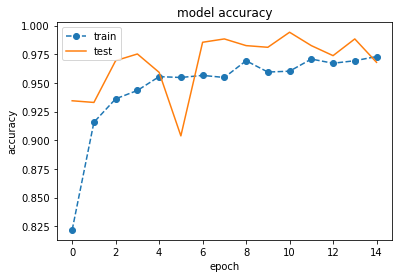

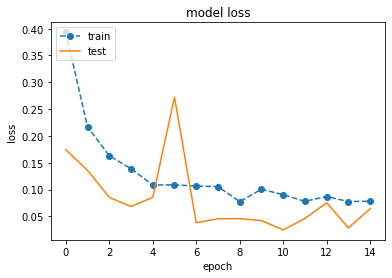

In [21]:
plt.plot(history.history['accuracy'],linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],linestyle='--', marker='o')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Generating a classification report

Shows how a classification report can be plotted using model training history.<br>

Uses the **scikit-learn** classification_report() function

In [31]:
K.clear_session() #seems to help prevent a random memoryleak

y_pred = mymodel.predict(testdata, verbose=1)

y_bool =[]
for data in y_pred:
    if data <0.5:
        y_bool.append(0)
    else:
        y_bool.append(1)



43/43 [==============================] - 4s 97ms/step


In [32]:
report = classification_report(testdata.classes, y_bool, output_dict=False)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       428
           1       0.93      1.00      0.96       428

    accuracy                           0.96       856
   macro avg       0.96      0.96      0.96       856
weighted avg       0.96      0.96      0.96       856

